In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import haversine as hs
import random
import string
import xgboost as xgb
import seaborn as sns
from datetime import datetime
from hurricaneModels import HurricaneModel
from haversine import haversine, Unit
from sklearn import svm
from sklearn.linear_model import LinearRegression

## Pre-Processing

In [2]:
# Importing Data
data_folder = glob.glob('matToPyData/*.csv')
data_folder.sort()
data_list = []

for file in data_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    df.drop(df.columns[3], inplace = True, axis = 1) # dropping fake numeric date
    data_list.append(df)

matToPyData/bestStormData_1.csv
matToPyData/bestStormData_2.csv
matToPyData/bestStormData_3.csv
matToPyData/bestStormData_4.csv
matToPyData/bestStormData_5.csv
matToPyData/bestStormData_6.csv
matToPyData/bestStormData_7.csv


In [3]:
# Importing Data Dates
dates_folder = glob.glob('matToPyDates/*.csv')
dates_folder.sort()
dates_list = []

for file in dates_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    dates_list.append(df)

matToPyDates/bestStormDates_1.csv
matToPyDates/bestStormDates_2.csv
matToPyDates/bestStormDates_3.csv
matToPyDates/bestStormDates_4.csv
matToPyDates/bestStormDates_5.csv
matToPyDates/bestStormDates_6.csv
matToPyDates/bestStormDates_7.csv


### Feature Engineering

In [4]:
random.seed(10)
final_data_list = []
for i in range(0, len(dates_list)):
    df = pd.concat([data_list[i], dates_list[i]], axis = 1)
    df.columns = ['lat', 'long', 'distance', 'azimuth', 'speed', 'cp', 'windspeed', 
                  'landfall_flag', 'overland_flag', 'maxwind', 'min_cp','rad_maxwind', 'eye_diam', 'pressure_isobar', 'rad_isobar' ,'date_time']
    #print(df.shape)
    
    df = df[df['lat'].between(-90,90)] # removing impossible long lat values
    df = df[df['long'].between(-180,180)]
    
    #print(df.shape)

    df['SID'] = random.choice(string.ascii_uppercase) + '_' + str(i + 1) #assigning IDs

    df['date_time'] = pd.to_datetime(df['date_time']) # converting dates to timedate

    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day_of_week
    df['month'] = df['date_time'].dt.month
    final_data_list.append(df)

In [5]:
def haversine(lat1, lat2, lon1, lon2):
    p1 = (lat1, lon1)
    p2 = (lat2, lon2)
    return hs.haversine(p1, p2)

# Adding between point distance as a feature
for data in final_data_list:
    data.loc[0, 'derived_distance'] = 0
    for i in range(1, len(data)):
        data.loc[i, 'derived_distance'] = haversine(data.iloc[i-1, :]['lat'], 
                                                     data.iloc[i, :]['lat'], 
                                                     data.iloc[i-1, :]['long'], 
                                                     data.iloc[i, :]['long'])

In [6]:
# Exporting all final preprocessed data:
k = 1
for data in final_data_list:
    data.to_csv('/Users/jasonluo/Documents/Hurricane_proj/finalPreprocData/final_dataset' + str(k) + '.csv', 
                index = False)
    k += 1

## Analysis

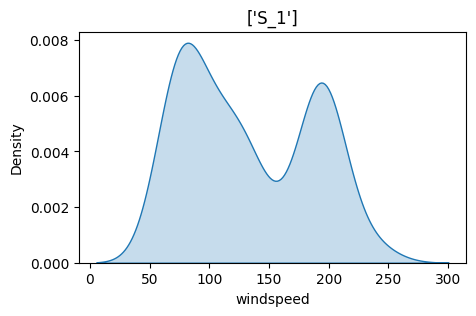

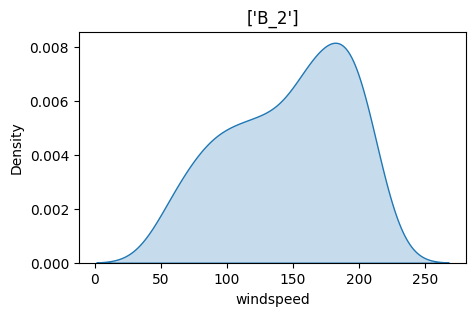

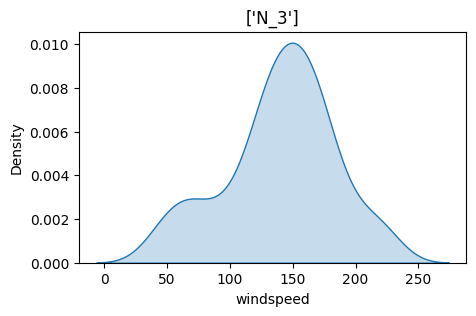

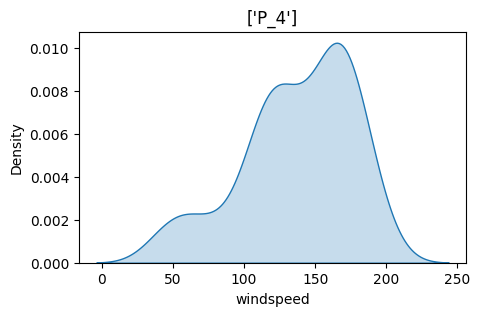

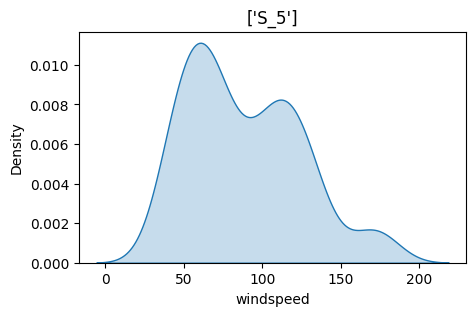

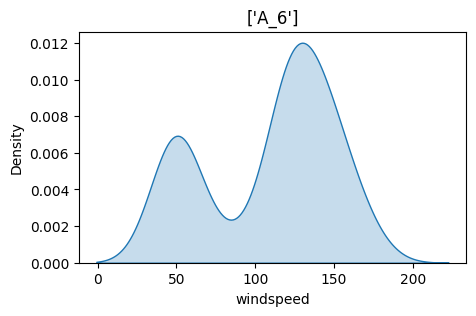

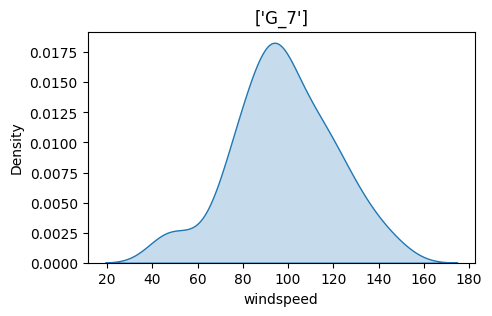

In [7]:

for i in range(0, len(final_data_list)):
    plt.figure(figsize = [5,3])
    plt.title(pd.unique(final_data_list[i]['SID']))
    sns.kdeplot(x = final_data_list[i]['windspeed'], 
                        fill = True)

In [8]:
Xfeats = ['lat', 'long', 'speed', 'cp', 'derived_distance', 'day', 'hour', 'month']
target = 'windspeed'
ratio = 0.5

# 3 models, XGB, SVR, and Linear Regression
model1 = xgb.XGBRegressor(n_estimators = 500, 
                          learning_rate = 0.01,
                          n_jobs = 10)
model2 = svm.SVR(kernel = 'linear', 
                 epsilon=0.2)
model3 = LinearRegression()

['S_1'] MSE: 404.26048349469716 MAE: 16.166449969090856 MAPE: 17.709330951067315
['B_2'] MSE: 2051.7066101333203 MAE: 38.906318842633674 MAPE: 31.20665886263857
['N_3'] MSE: 3685.9859939592557 MAE: 41.93247888630845 MAPE: 42.11557262110224
['P_4'] MSE: 1996.9715316366492 MAE: 32.37719318772591 MAPE: 21.722577980973053
['S_5'] MSE: 216.6388114569483 MAE: 13.230264808814267 MAPE: 14.90056951710916
['A_6'] MSE: 754.6624851076757 MAE: 23.744881923467467 MAPE: 28.4956916326289
['G_7'] MSE: 355.9016859658191 MAE: 16.521949747108657 MAPE: 15.972960093452052


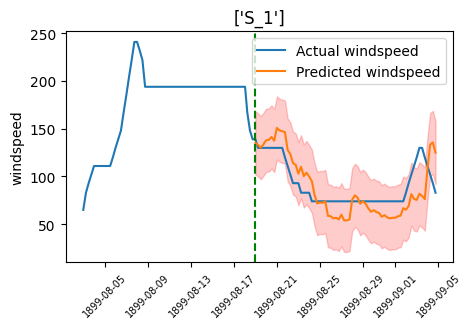

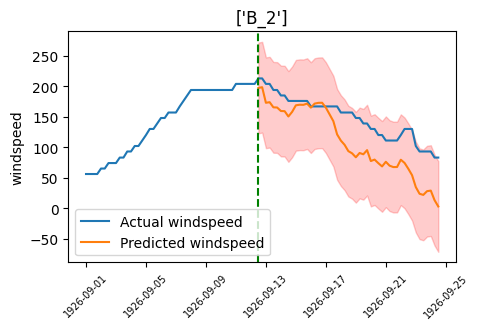

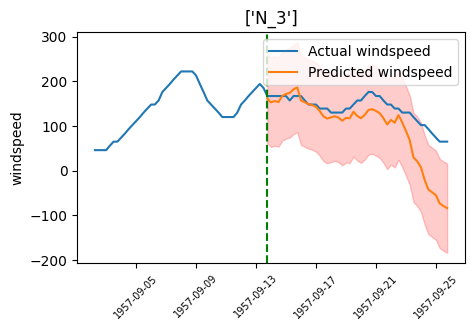

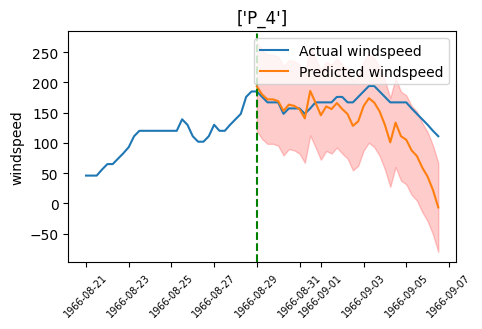

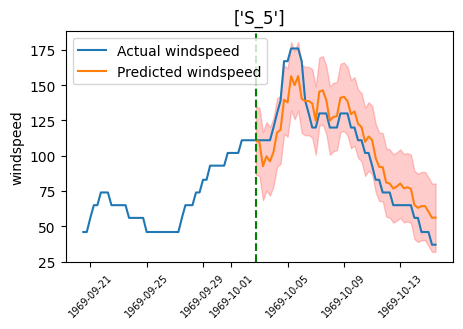

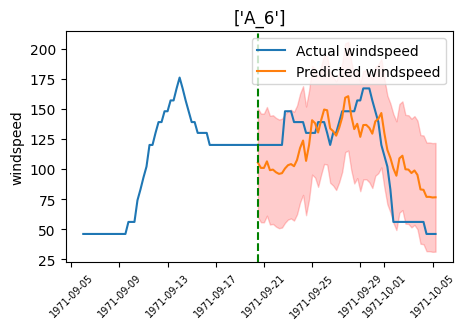

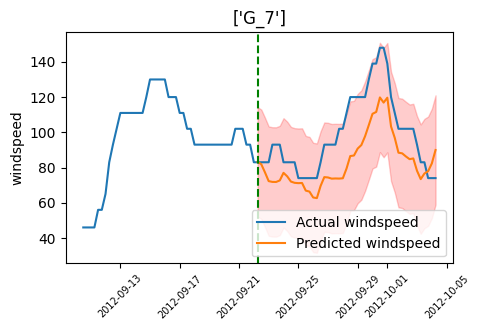

In [9]:
# Uses features at current time step
for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.split_train_predict(ratio, Xfeats, target, True)
    #Hmodel.plotACF(target)

['S_1'] MSE: 65.53688782977655 MAE: 6.649120845410567 MAPE: 7.608786388952199
['B_2'] MSE: 789.138760044023 MAE: 24.82387610298978 MAPE: 19.88440979795314
['N_3'] MSE: 1563.7456826667717 MAE: 30.94564742232951 MAPE: 29.13874736704348
['P_4'] MSE: 132.6692604163101 MAE: 8.859342853700115 MAPE: 5.917619570398663
['S_5'] MSE: 37.955409164622154 MAE: 4.915806567847164 MAPE: 5.57979183532478
['A_6'] MSE: 356.69153732370467 MAE: 15.747401046212774 MAPE: 18.226434336257604
['G_7'] MSE: 85.92303426768795 MAE: 7.513064900993803 MAPE: 7.262608548203773


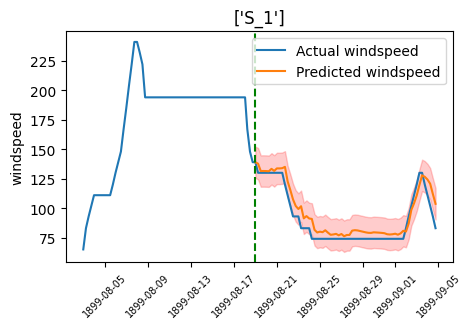

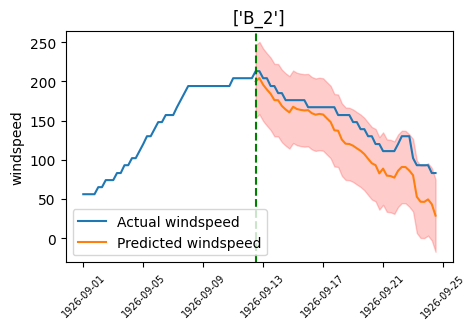

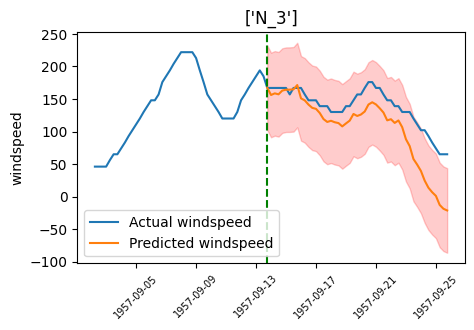

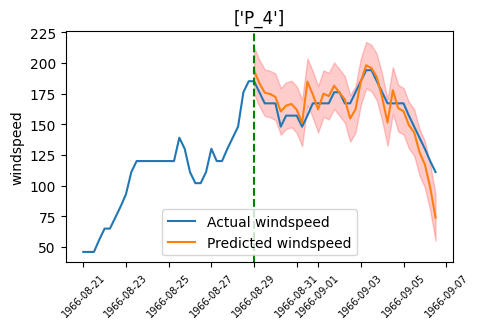

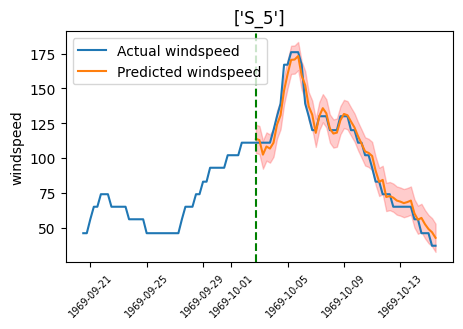

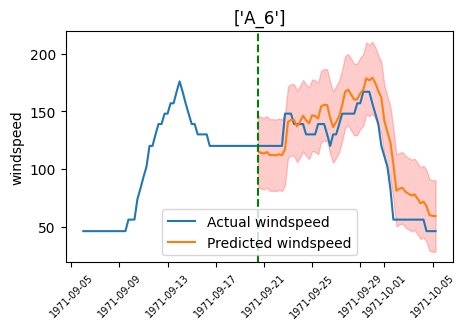

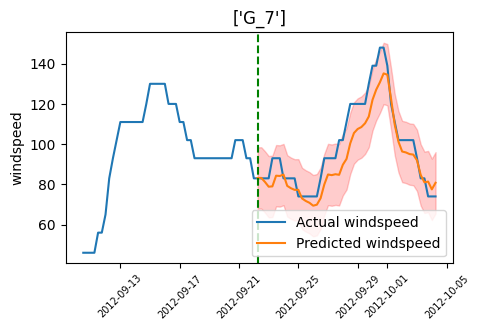

In [10]:
# With using lagged wind speed as a feature
# Lagged feature (in this case lagged windspeed) improves performance significantly

Xfeats = ['lat', 'long', 'speed', 'cp', 'derived_distance', 'day', 'hour', 'month', 'windspeed_lag1']
target = 'windspeed'
ratio = 0.5

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.addLaggedVar(target, lag = 1)
    Hmodel.split_train_predict(ratio, Xfeats, target, True)
    #Hmodel.plotACF(target)

In [11]:
# Using majority lagged features
# Lagged features include one timestep lag and two timestep lag
lagged_feats = ['lat', 'long', 'speed', 'cp', 'windspeed']
Xfeats = ['derived_distance', 'windspeed_lag1', 'lat_lag1', 'long_lag1', 'speed_lag1', 'cp_lag1',
          'windspeed_lag2', 'lat_lag2', 'long_lag2', 'speed_lag2', 'cp_lag2']
target = 'windspeed'
ratio = 0.5

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    for feats in lagged_feats:
        Hmodel.addLaggedVar(feats, lag = 1)
        Hmodel.addLaggedVar(feats, lag = 2)
    Hmodel.split_train_predict(ratio, Xfeats, target, False)
    #Hmodel.plotACF(target)
    

['S_1'] MSE: 20.085561973274533 MAE: 3.523965221569652 MAPE: 3.866593639235199
['B_2'] MSE: 91.59093534268763 MAE: 7.820336059325214 MAPE: 5.725839481061131
['N_3'] MSE: 1869.001774141719 MAE: 35.48976254852272 MAPE: 32.38560645895966
['P_4'] MSE: 3574.1168013464635 MAE: 46.619903575003995 MAPE: 30.705484435673252
['S_5'] MSE: 72.41980495713372 MAE: 5.764257196095551 MAPE: 5.975999479362434
['A_6'] MSE: 117.15772665377871 MAE: 8.128408351329718 MAPE: 8.523155036818258
['G_7'] MSE: 48.89518521763622 MAE: 5.132850468411268 MAPE: 4.998239897370364


### Time Series CV on Linear SVM
Time series cross validation for Hurricane 'S_1'

['S_1'] MSE: 2031.1513148466138 MAE: 42.30936492031019 MAPE: 36.62119459264083
['S_1'] MSE: 826.5165462638743 MAE: 25.46061111635457 MAPE: 27.64025693448388
['S_1'] MSE: 79.3178730989993 MAE: 7.853359780445076 MAPE: 8.576633005727665
['S_1'] MSE: 24.524504389608463 MAE: 2.497637000350808 MAPE: 2.348445537123712
['S_1'] MSE: 12.02959449788148 MAE: 1.9810378279366603 MAPE: 2.204854109796191
['S_1'] MSE: 8.3662152679124 MAE: 1.8102278291155915 MAPE: 2.070066196727616
['S_1'] MSE: 8.76371379306915 MAE: 1.8296077713150705 MAPE: 1.8599708872096121


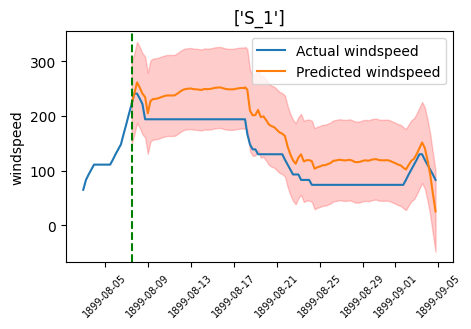

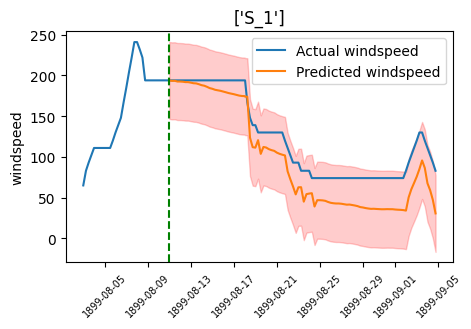

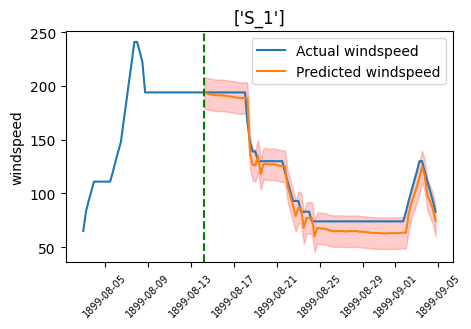

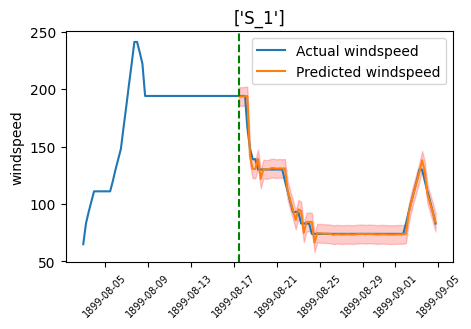

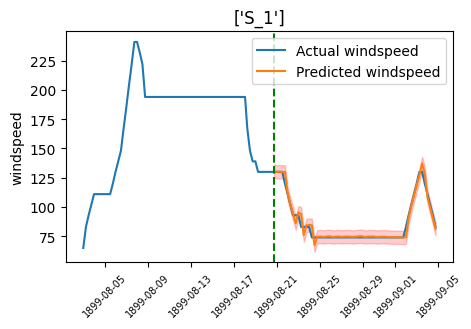

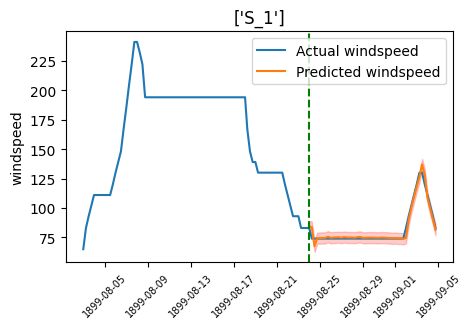

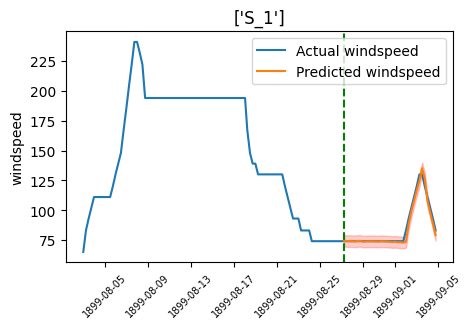

In [20]:
ratio_list = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
S1_data = final_data_list[0]
Hmodel = HurricaneModel(model2, S1_data)

# Only used previous 6 hrs 
for feats in lagged_feats:
    Hmodel.addLaggedVar(feats, lag = 1)
    
for ratio in ratio_list:
    Hmodel.split_train_predict(ratio, Xfeats, target, True)

### Comparing Linear SVR vs Linear Regression:
Comparing performance of 2 linear models

In [13]:
lagged_feats = ['lat', 'long', 'speed', 'cp', 'windspeed']
Xfeats = ['derived_distance', 'windspeed_lag1', 'lat_lag1', 'long_lag1', 'speed_lag1', 'cp_lag1',
          'windspeed_lag2', 'lat_lag2', 'long_lag2', 'speed_lag2', 'cp_lag2']
target = 'windspeed'
ratio = 0.6

# SVR
for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    for feats in lagged_feats:
        Hmodel.addLaggedVar(feats, lag = 1)
        Hmodel.addLaggedVar(feats, lag = 2)
    Hmodel.split_train_predict(ratio, Xfeats, target, False)
    #Hmodel.plotACF(target)


['S_1'] MSE: 12.722154030253078 MAE: 2.4768501780982266 MAPE: 2.901258716640104
['B_2'] MSE: 90.42243832549889 MAE: 7.822320951067654 MAPE: 5.953990620718809
['N_3'] MSE: 48.797477193371535 MAE: 6.031649389179767 MAPE: 4.681327661384562
['P_4'] MSE: 816.9063374892845 MAE: 24.39561721421314 MAPE: 16.04417512264387
['S_5'] MSE: 56.787326338993104 MAE: 4.844946069328387 MAPE: 5.193820596526085
['A_6'] MSE: 61.04263825023179 MAE: 5.021416020473888 MAPE: 5.116107076913747
['G_7'] MSE: 52.84938606372715 MAE: 5.416680510181626 MAPE: 5.1908966664003575


In [14]:
# Linear Regression
for data in final_data_list:
    Hmodel = HurricaneModel(model3, data)
    for feats in lagged_feats:
        Hmodel.addLaggedVar(feats, lag = 1)
        Hmodel.addLaggedVar(feats, lag = 2)
    Hmodel.split_train_predict(ratio, Xfeats, target, False)

['S_1'] MSE: 72.81124667542032 MAE: 7.148473235975593 MAPE: 8.34346052710115
['B_2'] MSE: 582.7911066965346 MAE: 20.26157987022518 MAPE: 17.0488469310242
['N_3'] MSE: 557.1148781070801 MAE: 20.391896154407856 MAPE: 16.092138878289298
['P_4'] MSE: 24986.380002801125 MAE: 130.73868166450936 MAPE: 85.5997283561203
['S_5'] MSE: 103.12417746437251 MAE: 7.636940164620523 MAPE: 7.977568528676236
['A_6'] MSE: 433.02683590595257 MAE: 18.083108716523036 MAPE: 21.20906209600536
['G_7'] MSE: 53.50038194053097 MAE: 5.5075071354687015 MAPE: 5.2264184763515855


In [15]:
# Decreasing training size:
ratio = 0.25

# SVR
for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    for feats in lagged_feats:
        Hmodel.addLaggedVar(feats, lag = 1)
        Hmodel.addLaggedVar(feats, lag = 2)
    Hmodel.split_train_predict(ratio, Xfeats, target, False)

['S_1'] MSE: 826.5165462638743 MAE: 25.46061111635457 MAPE: 27.64025693448388
['B_2'] MSE: 2876.9753770766597 MAE: 49.427252894415005 MAPE: 33.31580434264699
['N_3'] MSE: 3491.5507843575597 MAE: 52.369523927544456 MAPE: 37.64109378227022
['P_4'] MSE: 2362.8198342331907 MAE: 33.451608505366465 MAPE: 22.57364526447612
['S_5'] MSE: 188.45545007668267 MAE: 10.486344922460669 MAPE: 10.590066622171221
['A_6'] MSE: 171.96452263113744 MAE: 11.297071723556902 MAPE: 11.348259344702806
['G_7'] MSE: 146.37727362015772 MAE: 10.375536011822815 MAPE: 10.891420511052296


In [16]:
# Linear Regression
for data in final_data_list:
    Hmodel = HurricaneModel(model3, data)
    for feats in lagged_feats:
        Hmodel.addLaggedVar(feats, lag = 1)
        Hmodel.addLaggedVar(feats, lag = 2)
    Hmodel.split_train_predict(ratio, Xfeats, target, False)

['S_1'] MSE: 31077.356823675473 MAE: 157.5439510345954 MAPE: 171.01055838637978
['B_2'] MSE: 7378.330388675878 MAE: 76.20433289661808 MAPE: 49.229943578468664
['N_3'] MSE: 17672.269929203558 MAE: 116.68618721717701 MAPE: 82.15355695971883
['P_4'] MSE: 38512.873009982526 MAE: 164.2035655206598 MAPE: 109.15374729542462
['S_5'] MSE: 2357.3078434843737 MAE: 39.784073390620655 MAPE: 45.65993183216923
['A_6'] MSE: 3065.2004893702856 MAE: 48.909552520006926 MAPE: 41.299989763524046
['G_7'] MSE: 4154.06190929753 MAE: 61.44590207441301 MAPE: 64.81202882814546


## Differencing

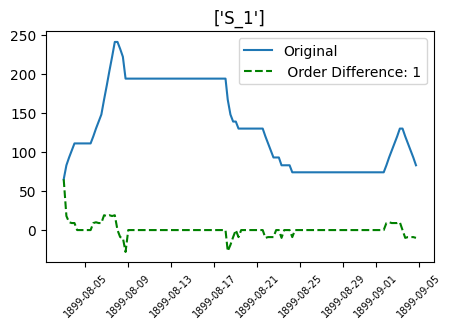

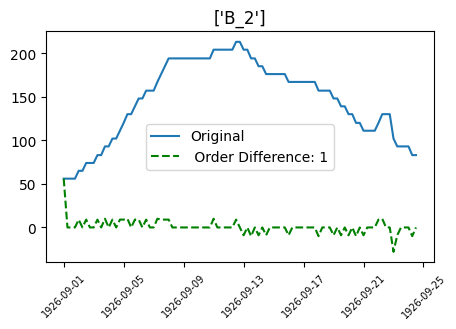

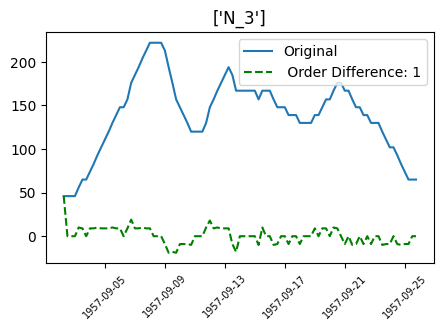

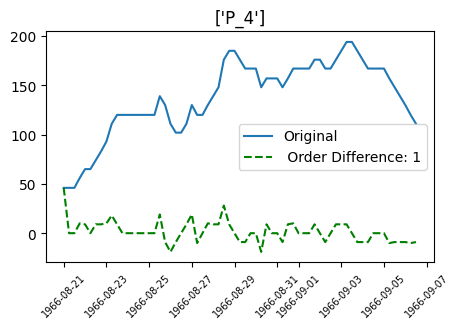

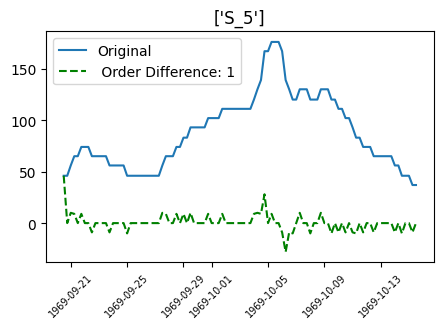

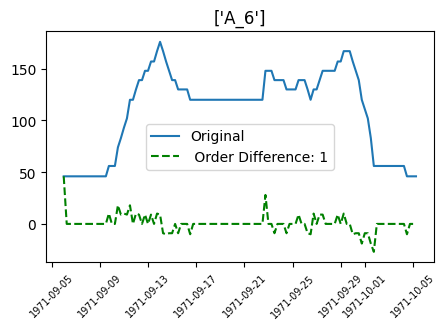

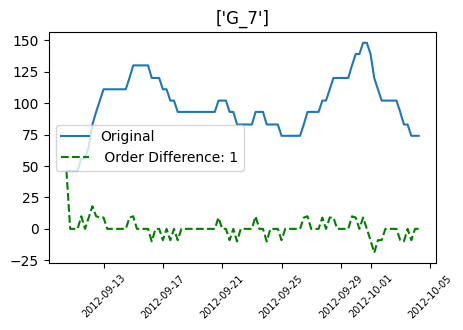

In [17]:
for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.plotDiff(target, order = 1)